In [2]:
from defect_dataset import DefectDataset
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # PIL -> Tensor and [0,255] -> [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # *We are not normalizing to our dataset's actual mean and stdev here*
])

train_dir = '/projectnb/npbssmic/ac25/Defect_Classification/unsupervised_dataset/train'  
train_dataset = DefectDataset(image_dir=train_dir, transform=transform)

val_dir = '/projectnb/npbssmic/ac25/Defect_Classification/unsupervised_dataset/val' 
val_dataset = DefectDataset(image_dir=val_dir, transform=transform)

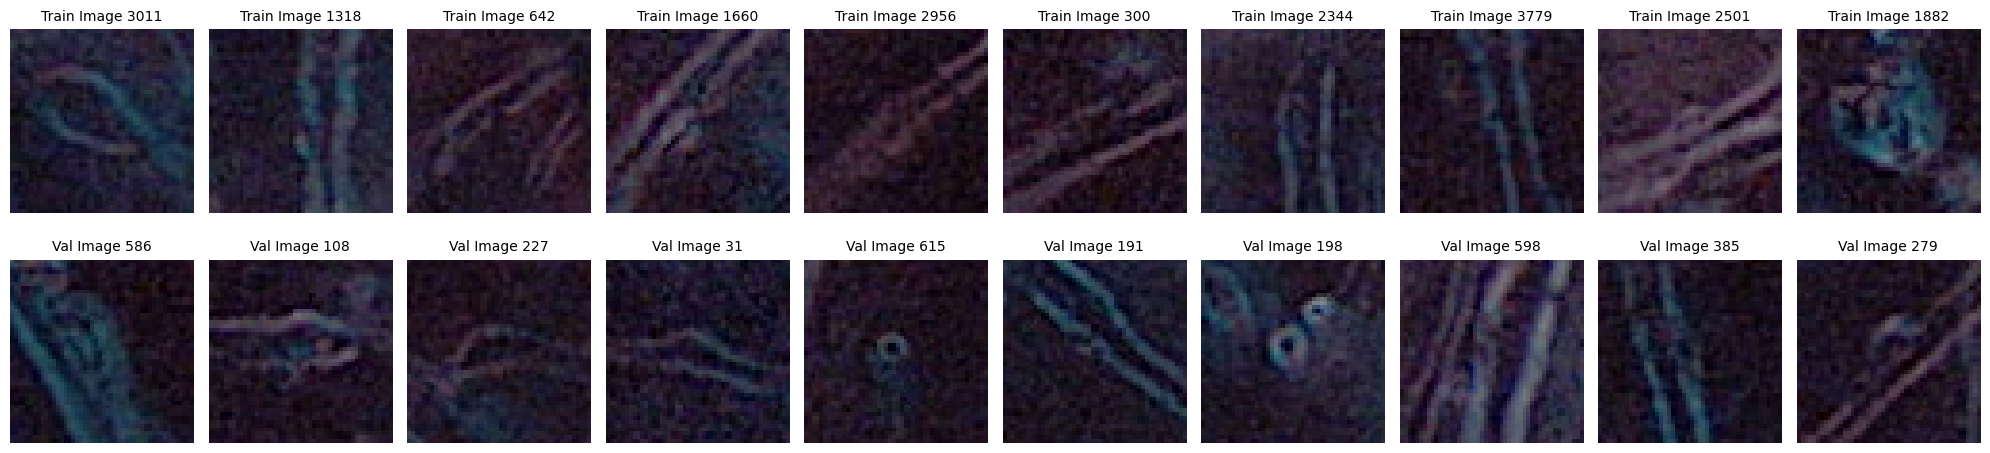

In [3]:
import random
import matplotlib.pyplot as plt

num_images = 10
fig, axs = plt.subplots(2, num_images, figsize=(20, 5))

# Show training images
for i in range(num_images):
    idx = random.randint(0, len(train_dataset) - 1)
    
    image_example = train_dataset[idx].numpy().transpose(1, 2, 0)
    image_example = ((image_example * 0.5) + 0.5) * 255
    image_example = image_example.astype('uint8')

    axs[0, i].imshow(image_example, interpolation='nearest')
    axs[0, i].set_title(f'Train Image {idx}', fontsize=10)
    axs[0, i].axis('off')

# Show validation images
for i in range(num_images):
    idx = random.randint(0, len(val_dataset) - 1)
    
    image_example = val_dataset[idx].numpy().transpose(1, 2, 0)
    image_example = ((image_example * 0.5) + 0.5) * 255
    image_example = image_example.astype('uint8')

    axs[1, i].imshow(image_example, interpolation='nearest')
    axs[1, i].set_title(f'Val Image {idx}', fontsize=10)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Create data loaders
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [6]:
# Instantiate model 
from cae import ConvAutoencoder

autoencoder = ConvAutoencoder(input_size=48, input_channels=3, feature_dim=128)  
print(autoencoder)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=2304, bias=True)
    (1): ReLU(inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(256, 3, 3))
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU(inpl

In [58]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import os

device = "cuda:0"

autoencoder = autoencoder.to(device)  
criterion = nn.MSELoss()  # Loss function for reconstruction (Mean Squared Error)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
num_epochs = 60
train_loss = []
val_loss = []

for epoch in tqdm(range(num_epochs)):
    autoencoder.train(True) 
    running_train_loss = 0.0
    
    for images in train_loader:
        images = images.to(device)  
        
        outputs = autoencoder(images)
        loss = criterion(outputs, images)  
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    autoencoder.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for i, v_data in enumerate(val_loader):
            val_images = v_data.to(device)
            v_outputs = autoencoder(val_images)
            v_loss = criterion(v_outputs, val_images)
            running_val_loss += v_loss.item()
    
    train_loss.append(running_train_loss)
    val_loss.append(running_val_loss)
    
    tqdm.write(f'Train Loss: {running_train_loss}  Val Loss: {running_val_loss}')

print('Finished training')

  2%|▏         | 1/60 [00:01<01:32,  1.56s/it]

Train Loss: 9.271307200193405  Val Loss: 0.32447369396686554


  3%|▎         | 2/60 [00:02<01:13,  1.26s/it]

Train Loss: 1.8937326166778803  Val Loss: 0.2888614172115922


  5%|▌         | 3/60 [00:03<01:06,  1.16s/it]

Train Loss: 1.717729551717639  Val Loss: 0.26545433420687914


  7%|▋         | 4/60 [00:04<01:02,  1.12s/it]

Train Loss: 1.6434269798919559  Val Loss: 0.2672536550089717


  8%|▊         | 5/60 [00:05<01:00,  1.09s/it]

Train Loss: 1.5910589341074228  Val Loss: 0.26079437229782343


 10%|█         | 6/60 [00:06<00:58,  1.08s/it]

Train Loss: 1.5560845797881484  Val Loss: 0.26160553749650717


 12%|█▏        | 7/60 [00:07<00:56,  1.07s/it]

Train Loss: 1.5295350784435868  Val Loss: 0.2395090153440833


 13%|█▎        | 8/60 [00:08<00:54,  1.06s/it]

Train Loss: 1.5229237666353583  Val Loss: 0.23566861636936665


 15%|█▌        | 9/60 [00:09<00:53,  1.05s/it]

Train Loss: 1.4934904323890805  Val Loss: 0.245324301533401


 17%|█▋        | 10/60 [00:10<00:52,  1.05s/it]

Train Loss: 1.4573020860552788  Val Loss: 0.22410461213439703


 18%|█▊        | 11/60 [00:12<00:51,  1.05s/it]

Train Loss: 1.3964066598564386  Val Loss: 0.2234906079247594


 20%|██        | 12/60 [00:13<00:50,  1.05s/it]

Train Loss: 1.3660936001688242  Val Loss: 0.22069004457443953


 22%|██▏       | 13/60 [00:14<00:49,  1.05s/it]

Train Loss: 1.3205898571759462  Val Loss: 0.21436463203281164


 23%|██▎       | 14/60 [00:15<00:48,  1.05s/it]

Train Loss: 1.2860787194222212  Val Loss: 0.2151872357353568


 25%|██▌       | 15/60 [00:16<00:47,  1.05s/it]

Train Loss: 1.260544901713729  Val Loss: 0.21295008342713118


 27%|██▋       | 16/60 [00:17<00:46,  1.05s/it]

Train Loss: 1.2357870256528258  Val Loss: 0.2028026357293129


 28%|██▊       | 17/60 [00:18<00:44,  1.04s/it]

Train Loss: 1.2472757073119283  Val Loss: 0.20028180815279484


 30%|███       | 18/60 [00:19<00:43,  1.04s/it]

Train Loss: 1.1790347779169679  Val Loss: 0.20318431314080954


 32%|███▏      | 19/60 [00:20<00:42,  1.04s/it]

Train Loss: 1.1447116006165743  Val Loss: 0.19575423561036587


 33%|███▎      | 20/60 [00:21<00:41,  1.04s/it]

Train Loss: 1.1320872539654374  Val Loss: 0.19027662789449096


 35%|███▌      | 21/60 [00:22<00:40,  1.05s/it]

Train Loss: 1.1061344523914158  Val Loss: 0.18743086606264114


 37%|███▋      | 22/60 [00:23<00:39,  1.04s/it]

Train Loss: 1.054964748211205  Val Loss: 0.17978430818766356


 38%|███▊      | 23/60 [00:24<00:38,  1.04s/it]

Train Loss: 1.0381893147714436  Val Loss: 0.17526007583364844


 40%|████      | 24/60 [00:25<00:37,  1.04s/it]

Train Loss: 1.012739690952003  Val Loss: 0.180500827729702


 42%|████▏     | 25/60 [00:26<00:36,  1.04s/it]

Train Loss: 1.0276219742372632  Val Loss: 0.17416981840506196


 43%|████▎     | 26/60 [00:27<00:35,  1.05s/it]

Train Loss: 0.9539806125685573  Val Loss: 0.16840965300798416


 45%|████▌     | 27/60 [00:28<00:34,  1.05s/it]

Train Loss: 0.9401193163357675  Val Loss: 0.1658463287167251


 47%|████▋     | 28/60 [00:29<00:33,  1.05s/it]

Train Loss: 0.9211999699473381  Val Loss: 0.1658549034036696


 48%|████▊     | 29/60 [00:30<00:32,  1.04s/it]

Train Loss: 0.9029012885876  Val Loss: 0.1703585204668343


 50%|█████     | 30/60 [00:31<00:31,  1.05s/it]

Train Loss: 0.896694197319448  Val Loss: 0.16762872273102403


 52%|█████▏    | 31/60 [00:32<00:30,  1.04s/it]

Train Loss: 0.881183703429997  Val Loss: 0.15977331064641476


 53%|█████▎    | 32/60 [00:33<00:29,  1.04s/it]

Train Loss: 0.8467166689224541  Val Loss: 0.15669811610132456


 55%|█████▌    | 33/60 [00:35<00:28,  1.04s/it]

Train Loss: 0.8374870936386287  Val Loss: 0.15813404181972146


 57%|█████▋    | 34/60 [00:36<00:27,  1.05s/it]

Train Loss: 0.8371245618909597  Val Loss: 0.1658087451942265


 58%|█████▊    | 35/60 [00:37<00:26,  1.05s/it]

Train Loss: 0.832017975859344  Val Loss: 0.1551021421328187


 60%|██████    | 36/60 [00:38<00:25,  1.05s/it]

Train Loss: 0.8015719288960099  Val Loss: 0.15380561212077737


 62%|██████▏   | 37/60 [00:39<00:24,  1.05s/it]

Train Loss: 0.7961835223250091  Val Loss: 0.15428610891103745


 63%|██████▎   | 38/60 [00:40<00:23,  1.05s/it]

Train Loss: 0.7904394529759884  Val Loss: 0.1569340405985713


 65%|██████▌   | 39/60 [00:41<00:22,  1.05s/it]

Train Loss: 0.7744074109941721  Val Loss: 0.15037807682529092


 67%|██████▋   | 40/60 [00:42<00:20,  1.04s/it]

Train Loss: 0.7564552114345133  Val Loss: 0.15442552883177996


 68%|██████▊   | 41/60 [00:43<00:19,  1.05s/it]

Train Loss: 0.7608093484304845  Val Loss: 0.14941144874319434


 70%|███████   | 42/60 [00:44<00:18,  1.05s/it]

Train Loss: 0.7387663712725043  Val Loss: 0.14699742989614606


 72%|███████▏  | 43/60 [00:45<00:17,  1.05s/it]

Train Loss: 0.7523254570551217  Val Loss: 0.14703990751877427


 73%|███████▎  | 44/60 [00:46<00:16,  1.05s/it]

Train Loss: 0.724710329901427  Val Loss: 0.14634933462366462


 75%|███████▌  | 45/60 [00:47<00:15,  1.05s/it]

Train Loss: 0.7157957684248686  Val Loss: 0.14584630262106657


 77%|███████▋  | 46/60 [00:48<00:14,  1.04s/it]

Train Loss: 0.7264113845303655  Val Loss: 0.1472960328683257


 78%|███████▊  | 47/60 [00:49<00:13,  1.05s/it]

Train Loss: 0.7096453215926886  Val Loss: 0.1458064215257764


 80%|████████  | 48/60 [00:50<00:12,  1.05s/it]

Train Loss: 0.7013274868950248  Val Loss: 0.14782905904576182


 82%|████████▏ | 49/60 [00:51<00:11,  1.05s/it]

Train Loss: 0.6939993915148079  Val Loss: 0.14420242374762893


 83%|████████▎ | 50/60 [00:52<00:10,  1.05s/it]

Train Loss: 0.6866071079857647  Val Loss: 0.14397644624114037


 85%|████████▌ | 51/60 [00:53<00:09,  1.05s/it]

Train Loss: 0.6833683312870562  Val Loss: 0.14341328619048


 87%|████████▋ | 52/60 [00:54<00:08,  1.05s/it]

Train Loss: 0.6890847524628043  Val Loss: 0.14361478574573994


 88%|████████▊ | 53/60 [00:56<00:07,  1.06s/it]

Train Loss: 0.6768348049372435  Val Loss: 0.1434056181460619


 90%|█████████ | 54/60 [00:57<00:06,  1.06s/it]

Train Loss: 0.6761063458397985  Val Loss: 0.14295385498553514


 92%|█████████▏| 55/60 [00:58<00:05,  1.05s/it]

Train Loss: 0.6709521790035069  Val Loss: 0.14456415688619018


 93%|█████████▎| 56/60 [00:59<00:04,  1.05s/it]

Train Loss: 0.6608909633941948  Val Loss: 0.14267126936465502


 95%|█████████▌| 57/60 [01:00<00:03,  1.05s/it]

Train Loss: 0.6517356531694531  Val Loss: 0.14180983835831285


 97%|█████████▋| 58/60 [01:01<00:02,  1.05s/it]

Train Loss: 0.651636659167707  Val Loss: 0.14092426840215921


 98%|█████████▊| 59/60 [01:02<00:01,  1.05s/it]

Train Loss: 0.6425554798915982  Val Loss: 0.1436115875840187


100%|██████████| 60/60 [01:03<00:00,  1.06s/it]

Train Loss: 0.6423377408646047  Val Loss: 0.14148021955043077
Finished training


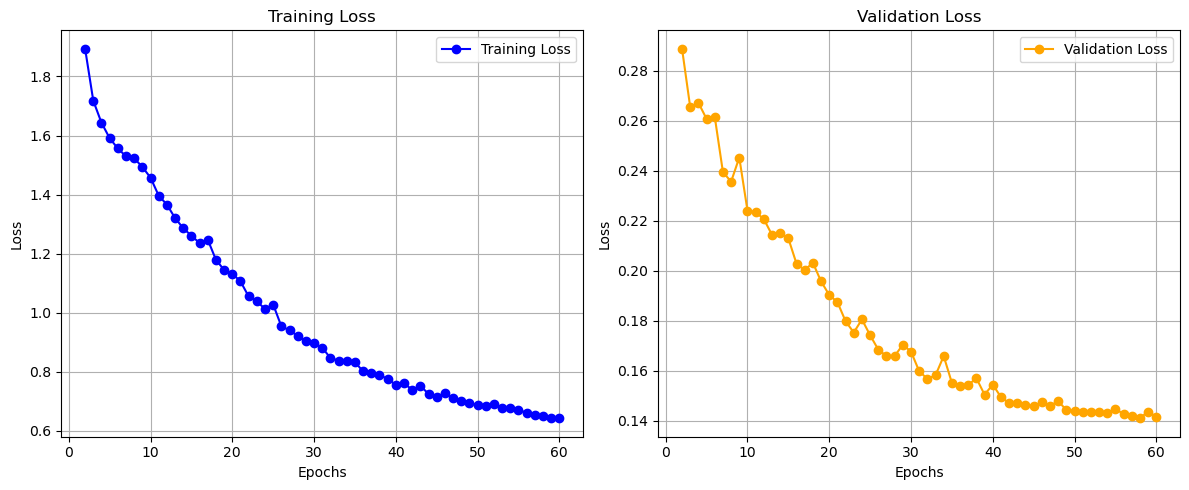

In [59]:
#Plotting results 

import matplotlib.pyplot as plt

epochs = list(range(2, num_epochs + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  

# Plotting training loss
ax1.plot(epochs, train_loss[1:], label='Training Loss', marker='o', color='blue')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting validation loss
ax2.plot(epochs, val_loss[1:], label='Validation Loss', marker='o', color='orange')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [61]:
#Save model 
save_path = '/projectnb/npbssmic/ac25/Defect_Classification/logs/train2/model.pt'
torch.save(autoencoder.state_dict(), save_path)